In [1]:
# PreRequisites: You have installed Revolution R Enterprise 7.5.0 or higher on the machine and SQL Server 2016 CTP3 or higher on the database server
# Install required R libraries for this walkthrough if they are not installed. 

if (!('ggmap' %in% rownames(installed.packages()))){
  install.packages('ggmap', lib='./libsforjupyter')
}
if (!('mapproj' %in% rownames(installed.packages()))){
  install.packages('mapproj', lib='./libsforjupyter')
}
if (!('ROCR' %in% rownames(installed.packages()))){
  install.packages('ROCR', lib='./libsforjupyter')
}
if (!('RODBC' %in% rownames(installed.packages()))){
  install.packages('RODBC', lib='./libsforjupyter')
}



In [2]:
# Add local lib directory to libPaths. The Jupyter windows user (LOCAL SERVICE) does not have write permission to global lib
.libPaths( c( .libPaths(), "./libsforjupyter") )

In [3]:
# Confirm you are working in your directory named after your username
# The username is also used as prefix for DB objects you will be creating in the tutorial 
username=gsub("[^a-zA-Z0-9]", "", basename(getwd()))
username

[1] "notebooks"

## Specifying the Database Connection

* RODBC style connection string
* Compute context can be
    * Server: rx Commands will run on the server closer to the data
    * Local: Commands will run locally on the client. Data need to brought to the client. 




In [4]:
connStr <- "Driver=SQL Server;Server=localhost;Database=nyctaxi;Trusted_Connection=true"

# Set ComputeContext. Needs a temp directory path to serialize R objects back and forth
sqlShareDir <- paste("C:\\AllShare\\",Sys.getenv("USERNAME"),sep="")
sqlWait <- TRUE
sqlConsoleOutput <- FALSE
cc <- RxInSqlServer(connectionString = connStr, shareDir = sqlShareDir, 
                    wait = sqlWait, consoleOutput = sqlConsoleOutput)
rxSetComputeContext(cc)

## Setting up R environment to query the database

* Define a DataSource (from a select query) to be used to explore the data and generate features from.
* Keep in mind that inDataSource is just a reference to the result dataset from the SQL query.

In [5]:

sampleDataQuery <- "select tipped, tip_amount, fare_amount, passenger_count,trip_time_in_secs,trip_distance, 
pickup_datetime, dropoff_datetime, 
cast(pickup_longitude as float) as pickup_longitude, 
cast(pickup_latitude as float) as pickup_latitude, 
cast(dropoff_longitude as float) as dropoff_longitude, 
cast(dropoff_latitude as float)  as dropoff_latitude,
cast(pickup_longitude as float) * 100 as pickup_longitude2, 
cast(pickup_latitude as float) * 100 as pickup_latitude2, 
cast(dropoff_longitude as float) * 100 as dropoff_longitude2, 
cast(dropoff_latitude as float) * 100 as dropoff_latitude2,
payment_type from nyctaxi_sample
tablesample (5 percent) repeatable (98052)
"

ptypeColInfo <- list(
  payment_type = list(
    type = "factor",
    levels = c("CSH", "CRD", "DIS", "NOC", "UNK"),
    newLevels= c("CSH", "CRD", "DIS", "NOC", "UNK")
  )
)

inDataSource <- RxSqlServerData(sqlQuery = sampleDataQuery, connectionString = connStr, colInfo = ptypeColInfo,
                                colClasses = c(pickup_longitude = "numeric", pickup_latitude = "numeric", 
                                               dropoff_longitude = "numeric", dropoff_latitude = "numeric"),
                                rowsPerRead=500)


## Understand the data

These functions give you basic information about your data source, such as its size and the names of columns in the set:

- `rxGetInfo`
- `rxGetVarInfo` (same as `rxGetInfo` with `getVarInfo = TRUE`)
- `rxGetVarNames`

The `rxGetInfo` function offers information on the data location, size, number of columns, and other related information.
    
## Numerical Data Summaries

We now move to quantitative summaries of the data. The `rxSummary` command provides output on the number of observations contained in a data set and for a particular column, the function provides output on the following:

 - Name
 - Mean value
 - Standard Deviation
 - Minimum and Maximum value
 - Number of valid observations
 - Number of missing observations

The `rxSummary` function takes a formula as its first argument, and the name of the data set as the second.

In addition, column subsets and transformations may also be computed as a sub-call to the function using the transforms (and so forth) commands.

If compute context is SQL server, it is executed closer to the data. 


In [6]:

################################
#        Data exploration      #
################################
# Summarize the Sampled Data
rxGetVarInfo(data = inDataSource)
rxSummary(~fare_amount:F(passenger_count,1,10), data = inDataSource)

Var 1: tipped, Type: integer
Var 2: tip_amount, Type: numeric
Var 3: fare_amount, Type: numeric
Var 4: passenger_count, Type: integer
Var 5: trip_time_in_secs, Type: numeric, Storage: int64
Var 6: trip_distance, Type: numeric
Var 7: pickup_datetime, Type: character
Var 8: dropoff_datetime, Type: character
Var 9: pickup_longitude, Type: numeric
Var 10: pickup_latitude, Type: numeric
Var 11: dropoff_longitude, Type: numeric
Var 12: dropoff_latitude, Type: numeric
Var 13: pickup_longitude2, Type: numeric
Var 14: pickup_latitude2, Type: numeric
Var 15: dropoff_longitude2, Type: numeric
Var 16: dropoff_latitude2, Type: numeric
Var 17: payment_type, Type: factor, no factor levels available

Call:
rxSummary(formula = ~fare_amount:F(passenger_count, 1, 10), data = inDataSource)

Summary Statistics Results for: ~fare_amount:F(passenger_count, 1, 10)
Data: inDataSource (RxSqlServerData Data Source)
Number of valid observations: 85499 
 
 Name                                 Mean    StdDev   Min  Max ValidObs
 fare_amount:F_passenger_count_1_10_T 12.2299 9.781275 -4.5 209 85499   
 MissingObs
 0         

Statistics by category (10 categories):

 Category                                     F_passenger_count_1_10_T Means   
 fare_amount for F(passenger_count,1,10,T)=1  1                        12.03399
 fare_amount for F(passenger_count,1,10,T)=2  2                        12.97843
 fare_amount for F(passenger_count,1,10,T)=3  3                        12.40670
 fare_amount for F(passenger_count,1,10,T)=4  4                        13.26184
 fare_amount for F(passenger_count,1,10,T)=5  5                        12.32626
 fare_amount for F(passenger_count,1,10,T)=6  6              

In [7]:
################################
#       Data Visualization     #
################################

cube1<-rxCube(tip_amount~F(passenger_count,1,7):F(trip_distance,0, 25), data = inDataSource)
cubePlot <- rxResultsDF(cube1)
cubePlot

,passenger_count,trip_distance,tip_amount,Counts
1,1,0,0.600593226537927,13671
2,2,0,0.593050847457627,2242
3,3,0,0.534090909090909,704
4,4,0,0.478851963746224,331
5,5,0,0.585539358600583,1029
6,6,0,0.501462450592885,759
7,7,0,NaN,0
8,1,1,0.865760928357182,20337
9,2,1,0.813743016759776,3759
10,3,1,0.726179286335944,1149


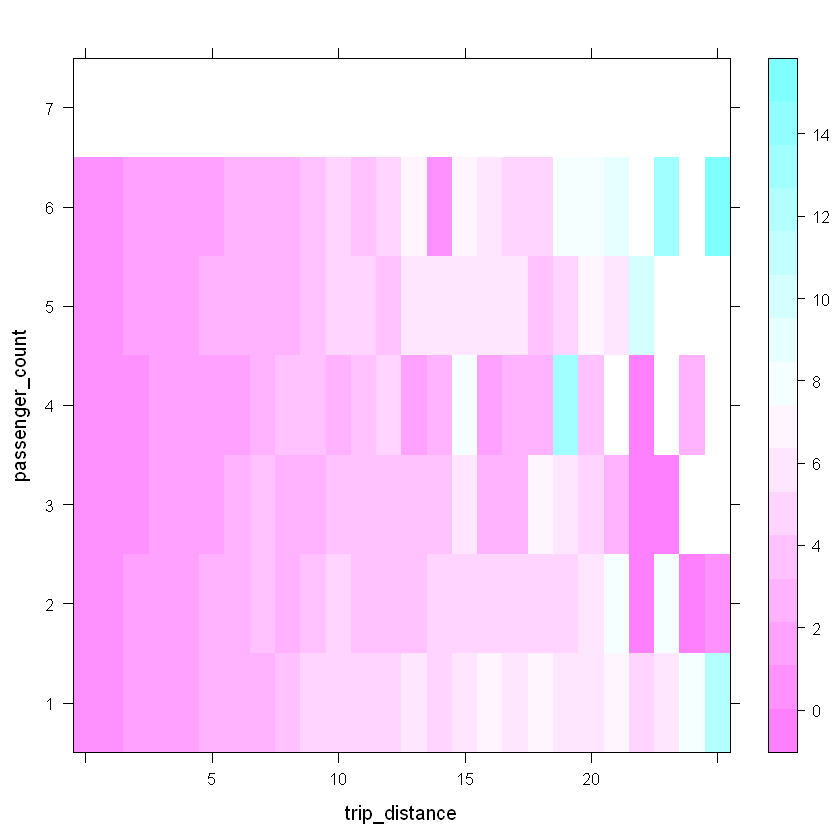

In [8]:
levelplot(tip_amount~trip_distance*passenger_count, data = cubePlot)

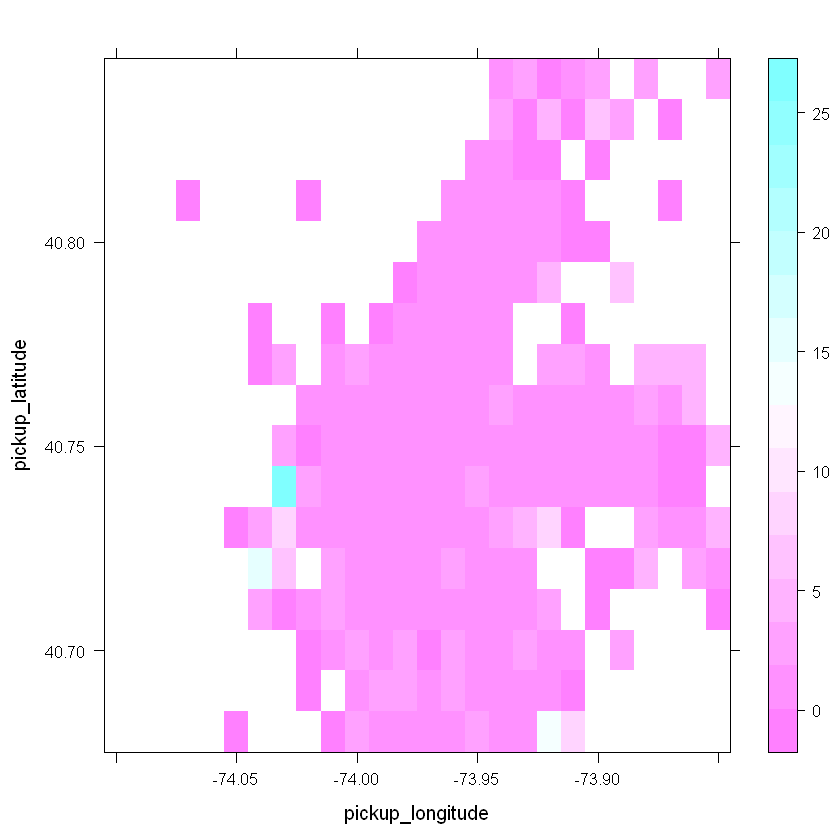

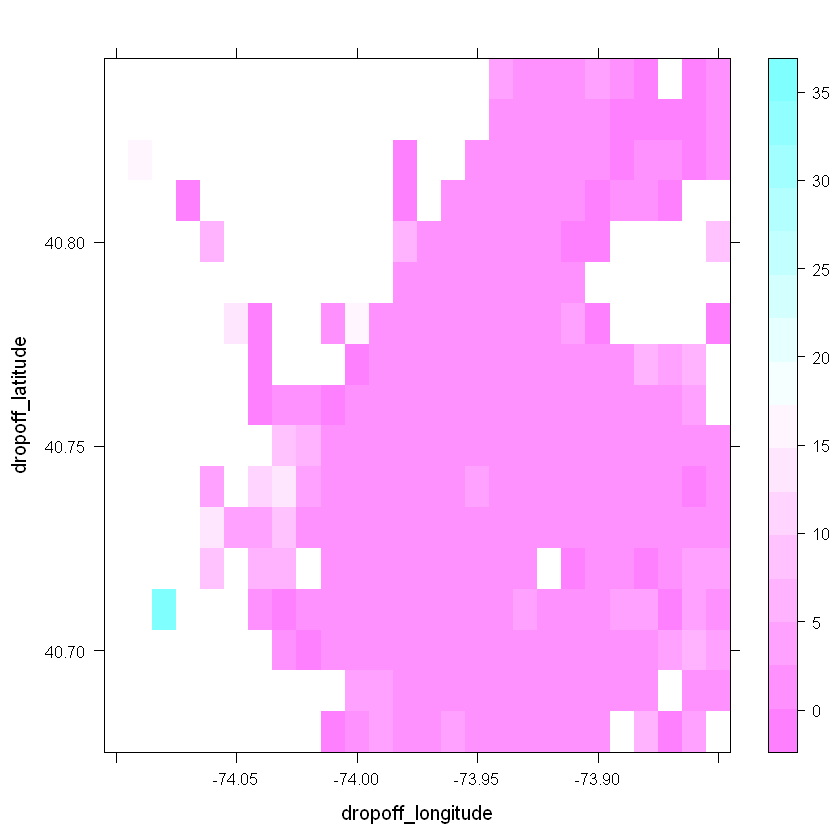

In [9]:
# More Cubeplots

cube2<-rxCube(tip_amount~F(pickup_longitude2,-7410, -7385, exclude=TRUE):F(pickup_latitude2,4068,4084, exclude = TRUE), data = inDataSource)
cubePlot2 <- rxResultsDF(cube2)
colnames(cubePlot2) <- c("pickup_longitude", "pickup_latitude", "tip_amount", "Counts")
cubePlot2 <- transform(cubePlot2, pickup_longitude = as.numeric(pickup_longitude)/100.0, pickup_latitude = as.numeric(pickup_latitude)/100.0)
levelplot(tip_amount~pickup_longitude*pickup_latitude, cubePlot2)

cube3<-rxCube(tip_amount~F(dropoff_longitude2,-7410, -7385, exclude=TRUE):F(dropoff_latitude2,4068,4084, exclude = TRUE), data = inDataSource)
cubePlot3 <- rxResultsDF(cube3)
colnames(cubePlot3) <- c("dropoff_longitude", "dropoff_latitude", "tip_amount", "Counts")
cubePlot3 <- transform(cubePlot3, dropoff_longitude = as.numeric(dropoff_longitude)/100.0, dropoff_latitude = as.numeric(dropoff_latitude)/100.0)
levelplot(tip_amount~dropoff_longitude*dropoff_latitude, cubePlot3)


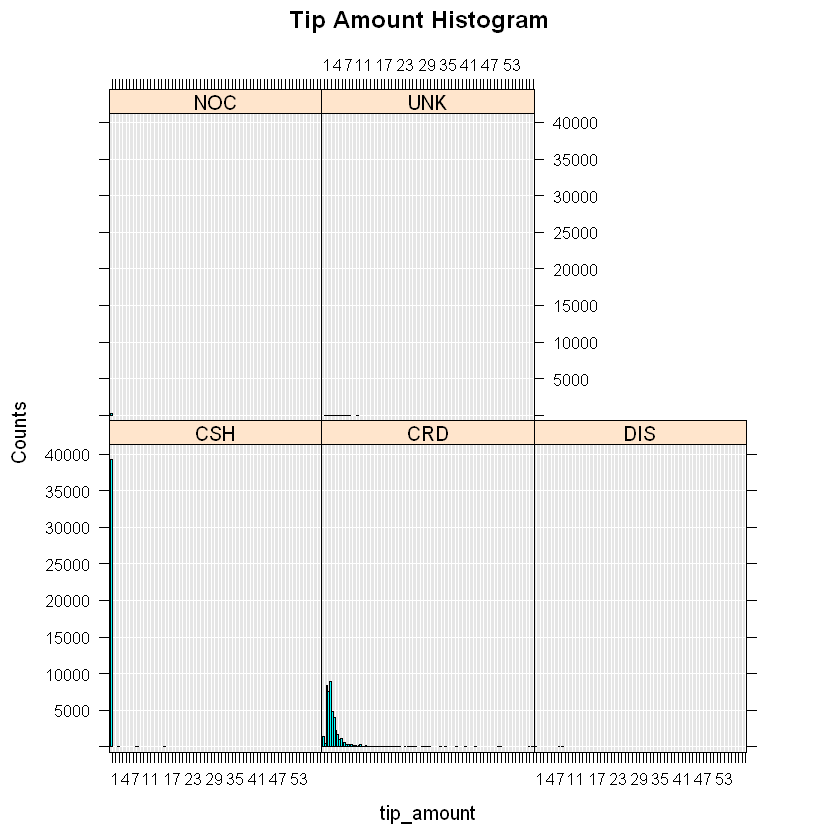

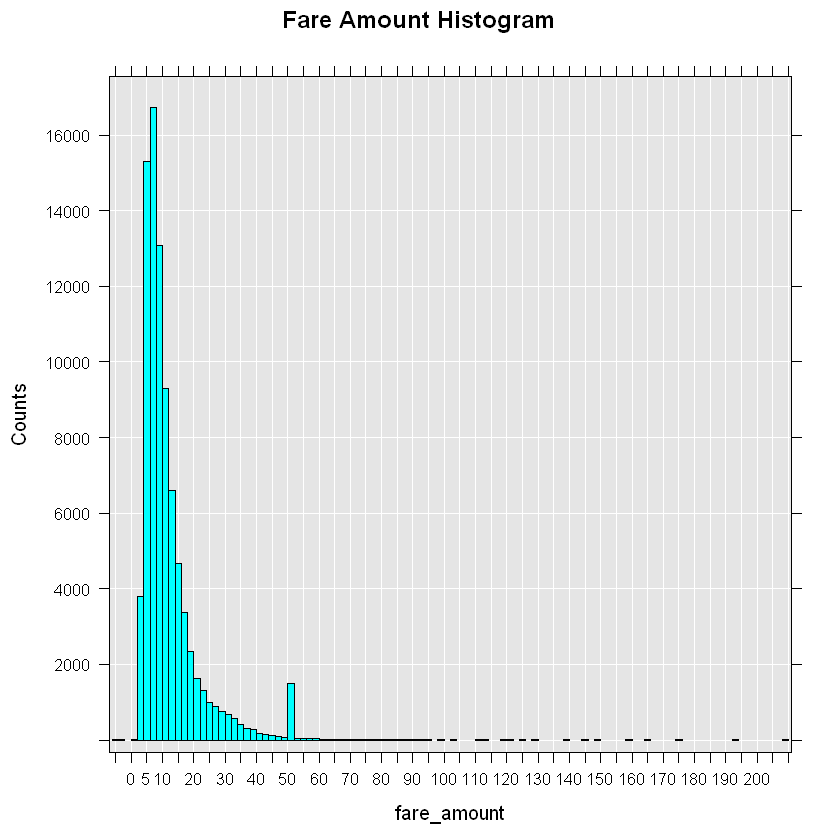

In [10]:
# Plot fare amount histogram on the SQL Server, and ship the plot to R client to display
rxHistogram(~tip_amount | payment_type, data = inDataSource, title = "Tip Amount Histogram")
rxHistogram(~fare_amount, data = inDataSource, title = "Fare Amount Histogram")

Loading required package: ggplot2
Loading required package: maps

 # ATTENTION: maps v3.0 has an updated 'world' map.        #
 # Many country borders and names have changed since 1990. #
 # Type '?world' or 'news(package="maps")'. See README_v3. #


Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=Times%20Square&sensor=false
Map from URL : http://maps.googleapis.com/maps/api/staticmap?center=40.759011,-73.984472&zoom=12&size=640x640&maptype=roadmap&sensor=false


======  JR-SQLR-DEMO  ( process  1 ) has started run at  2016-09-15 15:11:42.05  ====== 
Loading required package: ggplot2 
Loading required package: maps 
 
 # ATTENTION: maps v3.0 has an updated 'world' map.        # 
 # Many country borders and names have changed since 1990. # 
 # Type '?world' or 'news(package="maps")'. See README_v3. # 
 
 
 
[Microsoft][ODBC SQL Server Driver][SQL Server]Login failed for user 'JR-SQLR-DEMO\MSSQLSERVER01'. 
 
[Microsoft][ODBC Driver Manager] Connection not open 
 
ODBC Error in SQLDisconnect 
 
Could not open data source. 
Error in doTryCatch(return(expr), name, parentenv, handler) : 
  Could not open data source. 
Calls: source ... tryCatch -> tryCatchList -> tryCatchOne -> doTryCatch -> .Call 
In addition: Warning messages: 
1: In as.POSIXlt.POSIXct(x, tz) : unable to identify current timezone 'C': 
please set environment variable 'TZ' 
2: In as.POSIXlt.POSIXct(x, tz) : unknown timezone 'localtime' 
Execution halted 


ERROR: Error in rxCompleteClusterJob(hpcServerJob, consoleOutput, autoCleanup): No results available - final job state: failed


ERROR: Error in plot(myplots[[1]][["myplot"]]): object 'myplots' not found


Warning message:
: Removed 18 rows containing missing values (geom_point).

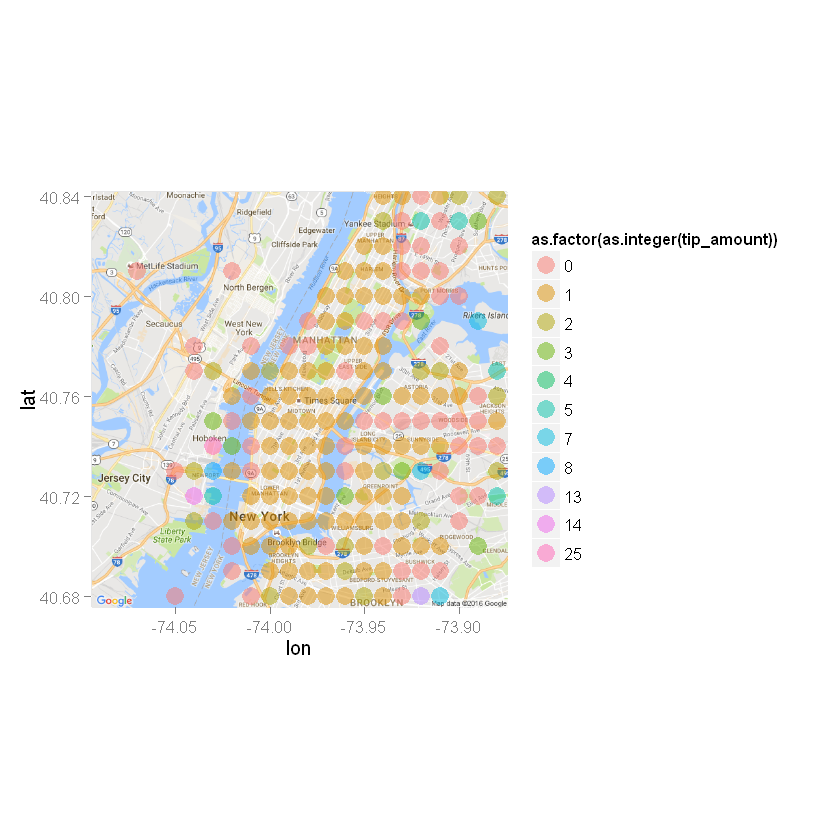

In [10]:
## MAP Visualization with rxExec
sampleDataQuery2 <- "select top 1000 tipped, tip_amount, fare_amount, passenger_count,trip_time_in_secs,trip_distance, 
    pickup_datetime, dropoff_datetime, 
pickup_longitude, 
pickup_latitude, 
dropoff_longitude, 
dropoff_latitude,
payment_type from nyctaxi_sample"


inDataSource2 <- RxSqlServerData(sqlQuery = sampleDataQuery2, connectionString = connStr, colInfo = ptypeColInfo,
                                 colClasses = c(pickup_longitude = "numeric", pickup_latitude = "numeric", 
                                                dropoff_longitude = "numeric", dropoff_latitude = "numeric"),
                                 rowsPerRead=500)

# Plot pickup location on map in SQL Server
# Define a function that plots points on a map
mapPlot <- function(inDataSource, googMap){
  library(ggmap)
  library(mapproj)
  
  # Open Source R functions require data to be brought back in memory into data frames. Use rxImport to bring in data. 
  # Remember: This whole function runs in the SQL Server Context. Data is brough to SQL Server memory
  ds <- rxImport(inDataSource)
  
  p<-ggmap(googMap)+
    geom_point(aes(x = pickup_longitude, y =pickup_latitude ), 
               data=ds, alpha =.5, color="darkred", size = 1.5)
  
  return(list(myplot=p))
}

library(ggmap)
library(mapproj)
# Get the map with Times Square, NY as the center. This is run on the R Client
gc <- geocode("Times Square", source = "google")
googMap <- get_googlemap(center = as.numeric(gc), zoom = 12, maptype = 'roadmap', color = 'color')
# Run the points plotting on SQL server. Passing in the map data as arg to remotely executed function. 
# The points are in the database and will be plotted on the map
myplots <- rxExec(mapPlot, inDataSource2, googMap, timesToRun = 1)
plot(myplots[[1]][["myplot"]])

ggmap(googMap)+
  geom_point(aes(x = pickup_longitude, y =pickup_latitude, color = as.factor(as.integer(tip_amount)) ), 
             data=subset(cubePlot2, Counts > 0), alpha =.5,  size = 5)



In [11]:
################################
#      Feature engineering     #
################################
# Define a function in open source R to calculate the direct distance between pickup and dropoff as a new feature 
# Use Haversine Formula: https://en.wikipedia.org/wiki/Haversine_formula
env <- new.env()

env$ComputeDist <- function(pickup_long, pickup_lat, dropoff_long, dropoff_lat){
  R <- 6371/1.609344 #radius in mile
  delta_lat <- dropoff_lat - pickup_lat
  delta_long <- dropoff_long - pickup_long
  degrees_to_radians = pi/180.0
  a1 <- sin(delta_lat/2*degrees_to_radians)
  a2 <- as.numeric(a1)^2
  a3 <- cos(pickup_lat*degrees_to_radians)
  a4 <- cos(dropoff_lat*degrees_to_radians)
  a5 <- sin(delta_long/2*degrees_to_radians)
  a6 <- as.numeric(a5)^2
  a <- a2+a3*a4*a6
  c <- 2*atan2(sqrt(a),sqrt(1-a))
  d <- R*c
  return (d)
}

featuretable = paste0(username , "_features")
#Define the featureDataSource to be used to store the features, specify types of some variables as numeric
featureDataSource = RxSqlServerData(table = featuretable, 
                                    colClasses = c(pickup_longitude = "numeric", pickup_latitude = "numeric", 
                                                   dropoff_longitude = "numeric", dropoff_latitude = "numeric",
                                                   passenger_count  = "numeric", trip_distance  = "numeric",
                                                   trip_time_in_secs  = "numeric", direct_distance  = "numeric"),
                                    connectionString = connStr)

# Create feature (direct distance) by calling rxDataStep() function, which calls the env$ComputeDist function to process records
# And output it along with other variables as features to the featureDataSource
# This will be the feature set for training machine learning models
start.time <- proc.time()
rxDataStep(inData =   inDataSource, outFile = featureDataSource,  overwrite = TRUE, 
           varsToKeep=c("tipped", "fare_amount", "passenger_count","trip_time_in_secs", 
                        "trip_distance", "pickup_datetime", "dropoff_datetime", "pickup_longitude",
                        "pickup_latitude","dropoff_longitude", "dropoff_latitude"),
           transforms = list(direct_distance=ComputeDist(pickup_longitude, pickup_latitude, dropoff_longitude, 
                                                         dropoff_latitude)),
           transformEnvir = env, rowsPerRead=10000, reportProgress = 3)
used.time <- proc.time() - start.time
print(paste("It takes CPU Time=", round(used.time[1]+used.time[2],2), 
            " seconds, Elapsed Time=", round(used.time[3],2), " seconds to generate features.", sep=""))


======  JR-SQLR-DEMO  ( process  1 ) has started run at  2016-09-15 15:11:45.91  ====== 
 
'varsToKeep' and 'varsToDrop' not supported for this data source type. 
 
[Microsoft][ODBC SQL Server Driver][SQL Server]Login failed for user 'JR-SQLR-DEMO\MSSQLSERVER01'. 
Caught exception in file: CxAnalysis.cpp, line: 5682. ThreadID: 6808 Rethrowing. 
Caught exception in file: CxAnalysis.cpp, line: 5249. ThreadID: 6808 Rethrowing. 
 
[Microsoft][ODBC Driver Manager] Connection not open 
 
ODBC Error in SQLDisconnect 
Error in doTryCatch(return(expr), name, parentenv, handler) : 
  [Microsoft][ODBC SQL Server Driver][SQL Server]Login failed for user 'JR-SQLR-DEMO\MSSQLSERVER01'. 
Calls: source ... tryCatch -> tryCatchList -> tryCatchOne -> doTryCatch -> .Call 
In addition: Warning messages: 
1: In as.POSIXlt.POSIXct(x, tz) : unable to identify current timezone 'C': 
please set environment variable 'TZ' 
2: In as.POSIXlt.POSIXct(x, tz) : unknown timezone 'localtime' 
Execution halted 


ERROR: Error in rxCompleteClusterJob(hpcServerJob, consoleOutput, autoCleanup): No results available - final job state: failed


[1] "It takes CPU Time=0.14 seconds, Elapsed Time=2.3 seconds to generate features."


In [13]:
# Do feature engineering through a SQL Query

ptypeColInfo <- list(
  payment_type = list(
    type = "factor",
    levels = c("CSH", "CRD", "DIS", "NOC", "UNK"),
    newLevels= c("CSH", "CRD", "DIS", "NOC", "UNK")
  )
)
# Alternatively, use a user defined function in SQL to create features
# Sometimes, feature engineering in SQL might be faster than R
# You need to choose the most efficient way based on real situation
# Here, featureEngineeringQuery is just a reference to the result from a SQL query. 
featureEngineeringQuery = "SELECT tipped, fare_amount, passenger_count,trip_time_in_secs,trip_distance, 
pickup_datetime, dropoff_datetime, 
dbo.fnCalculateDistance(pickup_latitude, pickup_longitude,  dropoff_latitude, dropoff_longitude) as direct_distance,
pickup_latitude, pickup_longitude,  dropoff_latitude, dropoff_longitude, payment_type
FROM nyctaxi_sample
tablesample (70 percent) repeatable (98052) where payment_type = 'CRD'
"
featureDataSource = RxSqlServerData(sqlQuery = featureEngineeringQuery, colInfo = ptypeColInfo,
                                    colClasses = c(pickup_longitude = "numeric", pickup_latitude = "numeric", 
                                                   dropoff_longitude = "numeric", dropoff_latitude = "numeric",
                                                   passenger_count  = "numeric", trip_distance  = "numeric",
                                                   trip_time_in_secs  = "numeric", direct_distance  = "numeric", fare_amount="numeric"),
                                    connectionString = connStr)

# summarize the feature table after the feature set is created
rxGetVarInfo(data = featureDataSource)

Var 1: tipped, Type: integer
Var 2: fare_amount, Type: numeric
Var 3: passenger_count, Type: numeric
Var 4: trip_time_in_secs, Type: numeric
Var 5: trip_distance, Type: numeric
Var 6: pickup_datetime, Type: character
Var 7: dropoff_datetime, Type: character
Var 8: direct_distance, Type: numeric
Var 9: pickup_latitude, Type: numeric
Var 10: pickup_longitude, Type: numeric
Var 11: dropoff_latitude, Type: numeric
Var 12: dropoff_longitude, Type: numeric
Var 13: payment_type, Type: factor, no factor levels available

In [14]:
################################
#        Training models       #
################################
# build classification model to predict tipped or not
system.time(logitObj <- rxLogit(tipped ~  passenger_count + trip_distance + trip_time_in_secs + direct_distance, data = featureDataSource))
summary(logitObj)

   user  system elapsed 
   0.11    0.00    9.87 

Call:
rxLogit(formula = tipped ~ passenger_count + trip_distance + 
    trip_time_in_secs + direct_distance, data = featureDataSource)

Logistic Regression Results for: tipped ~ passenger_count +
    trip_distance + trip_time_in_secs + direct_distance
Data: featureDataSource (RxSqlServerData Data Source)
Dependent variable(s): tipped
Total independent variables: 5 
Number of valid observations: 642074
Number of missing observations: 0 
-2*LogLikelihood: 174814.668 (Residual deviance on 642069 degrees of freedom)
 
Coefficients:
                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)        3.576e+00  1.142e-02 313.093 2.22e-16 ***
passenger_count   -6.494e-02  4.840e-03 -13.416 2.22e-16 ***
trip_distance      5.197e-07  4.110e-06   0.126  0.89937    
trip_time_in_secs -1.401e-07  3.479e-07  -0.403  0.68708    
direct_distance   -4.674e-04  1.694e-04  -2.759  0.00579 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Condition number of final varian

In [15]:
################################
#        Make predictions      #
################################
# predict and write the prediction results back to SQL Server table
outputtable = paste0(username,"_scoreoutput")
scoredOutput <- RxSqlServerData(
  connectionString = connStr,
  table = outputtable
)

rxPredict(modelObject = logitObj, data = featureDataSource, outData = scoredOutput, 
          predVarNames = "Score", type = "response", writeModelVars = TRUE, overwrite = TRUE)

RxSqlServerData Source
table: notebooks_scoreoutput
useFastRead: TRUE
connectionString: Driver=SQL Server;Server=localhost;Database=nyctaxi;Trusted_Connection=true

Rows Read: 101, Total Rows Processed: 101, Total Chunk Time: 0.015 seconds 


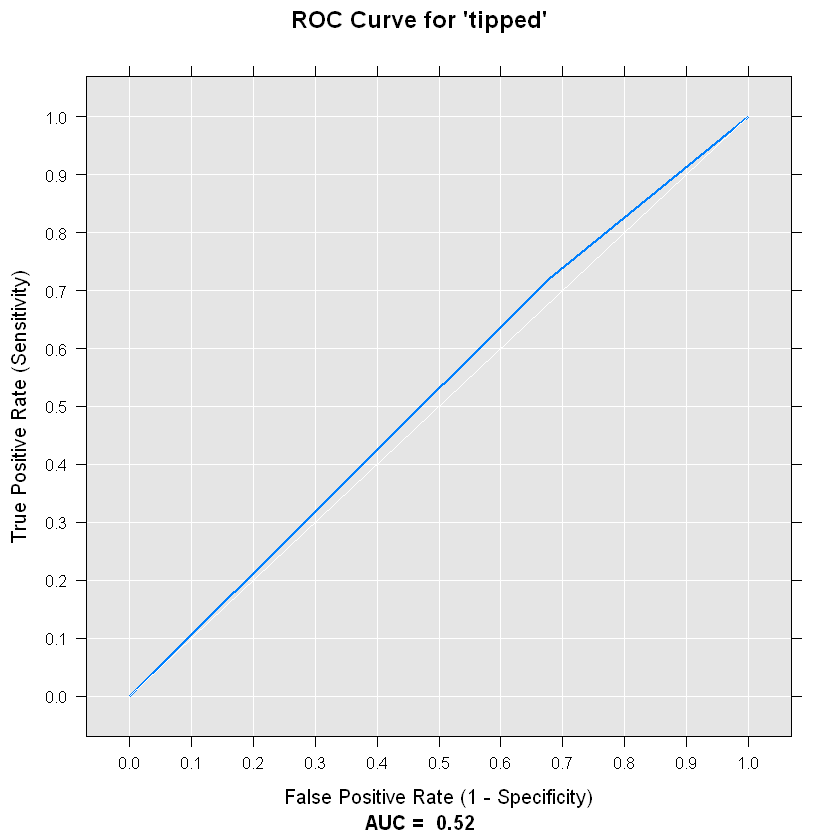

In [16]:
################################
#        Model evaluation      #
################################
# plot ROC curve from SQL Context
rxRocCurve( "tipped", "Score", scoredOutput)

In [22]:
################################
#   Model operationalization   #
################################
# First, serialize a model and put it into a database table
modelbin <- serialize(logitObj, NULL)
modelbinstr=paste(modelbin, collapse="")

library(RODBC)
conn <- odbcDriverConnect(connStr )

# Persist model by calling a stored procedure from SQL
q<-paste("EXEC PersistModel @m='", modelbinstr,"'", sep="")
sqlQuery (conn, q)

character(0)

In [23]:
# Consume Model through Stored Proc Execution
# There are two stored Procs - One for predicting on single observation and another for predicting a batch of observations

# Single Observation prediction
q = "EXEC PredictTipSingleMode @passenger_count=1, @trip_distance=2.5, @trip_time_in_secs=631, 
     @pickup_latitude=40.763958,@pickup_longitude=-73.973373, @dropoff_latitude=40.782139,@dropoff_longitude=-73.977303"
sqlQuery (conn, q)

q = "EXEC PredictTipSingleMode @passenger_count=2, @trip_distance=35.3, @trip_time_in_secs=2939, 
@pickup_latitude=40.75984,@pickup_longitude=-73.9754, @dropoff_latitude=41.0496,@dropoff_longitude=-73.54097"
sqlQuery (conn, q)

# Batch mode prediction. Score all data that were not part of the training dataset and select top 10 to preedict
input = "N'select top 10 a.passenger_count as passenger_count, 
	a.trip_time_in_secs as trip_time_in_secs,
	a.trip_distance as trip_distance,
	a.dropoff_datetime as dropoff_datetime,  
	dbo.fnCalculateDistance(pickup_latitude, pickup_longitude, dropoff_latitude,dropoff_longitude) as direct_distance , fare_amount, payment_type
from
(
	select medallion, hack_license, pickup_datetime, passenger_count,trip_time_in_secs,trip_distance,  
		dropoff_datetime, pickup_latitude, pickup_longitude, dropoff_latitude, dropoff_longitude, fare_amount, payment_type
	from nyctaxi_sample where payment_type = ''CRD''
)a
left outer join
(
select medallion, hack_license, pickup_datetime
from nyctaxi_sample
tablesample (70 percent) repeatable (98052) where payment_type = ''CRD''
)b
on a.medallion=b.medallion and a.hack_license=b.hack_license and a.pickup_datetime=b.pickup_datetime
where b.medallion is null
'"
q<-paste("EXEC PredictTipBatchMode @inquery = ", input, sep="")
sqlQuery (conn, q)


,Score
1,0.9709873


,Score
1,0.9686834


,Score
1,0.9709887
2,0.9709862
3,0.9709377
4,0.9709939
5,0.9709968
6,0.9709873
7,0.9710026
8,0.970984
9,0.9709647
10,0.9709884
